## P01: A* Algorithm

In [1]:
from classes.PriorityQueue import PriorityQueue
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from classes.Stack import Stack
from classes.Queue import Queue
from typing import Union
import networkx as nx
from utility import *
import pandas as pd
import numpy as np
import string
import math
import glob

#### **Maze Load and Plotting**

In [12]:
# Maps 0 | 1 | 2 values into White, Gray and Orange, respectively
cmap = ListedColormap(['white', 'gray', 'orange', 'green'])
maze_path = 'datasets/*.csv'
maze_dict = {}

csv_files = enumerate(glob.glob(maze_path))
for file_path in csv_files:
    var_name = file_path[1].split('/')[1].split('.')[0]
    maze_dict[var_name] = pd.read_csv(file_path[1], header=None).to_numpy()

In [13]:
def maze_plotter(data: np.ndarray):
    """
    A helper function to plot 2D data into a maze
    """
    im = plt.imshow(data[::], interpolation='none', vmin=0, vmax=3, aspect='equal', cmap=cmap)

    # Get the axis
    ax=plt.gca()

    # Major ticks
    ax.set_xticks(np.arange(0, data.shape[1], 1))
    ax.set_yticks(np.arange(0, data.shape[0], 1))

    # Minor ticks
    ax.set_xticks(np.arange(-.5, data.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, data.shape[0], 1), minor=True)

    # Invert the axis
    ax.set_ylim(ax.get_ylim()[::])
    ax.set_xlim(ax.get_xlim()[::])
    ax.xaxis.tick_top()

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
    return im

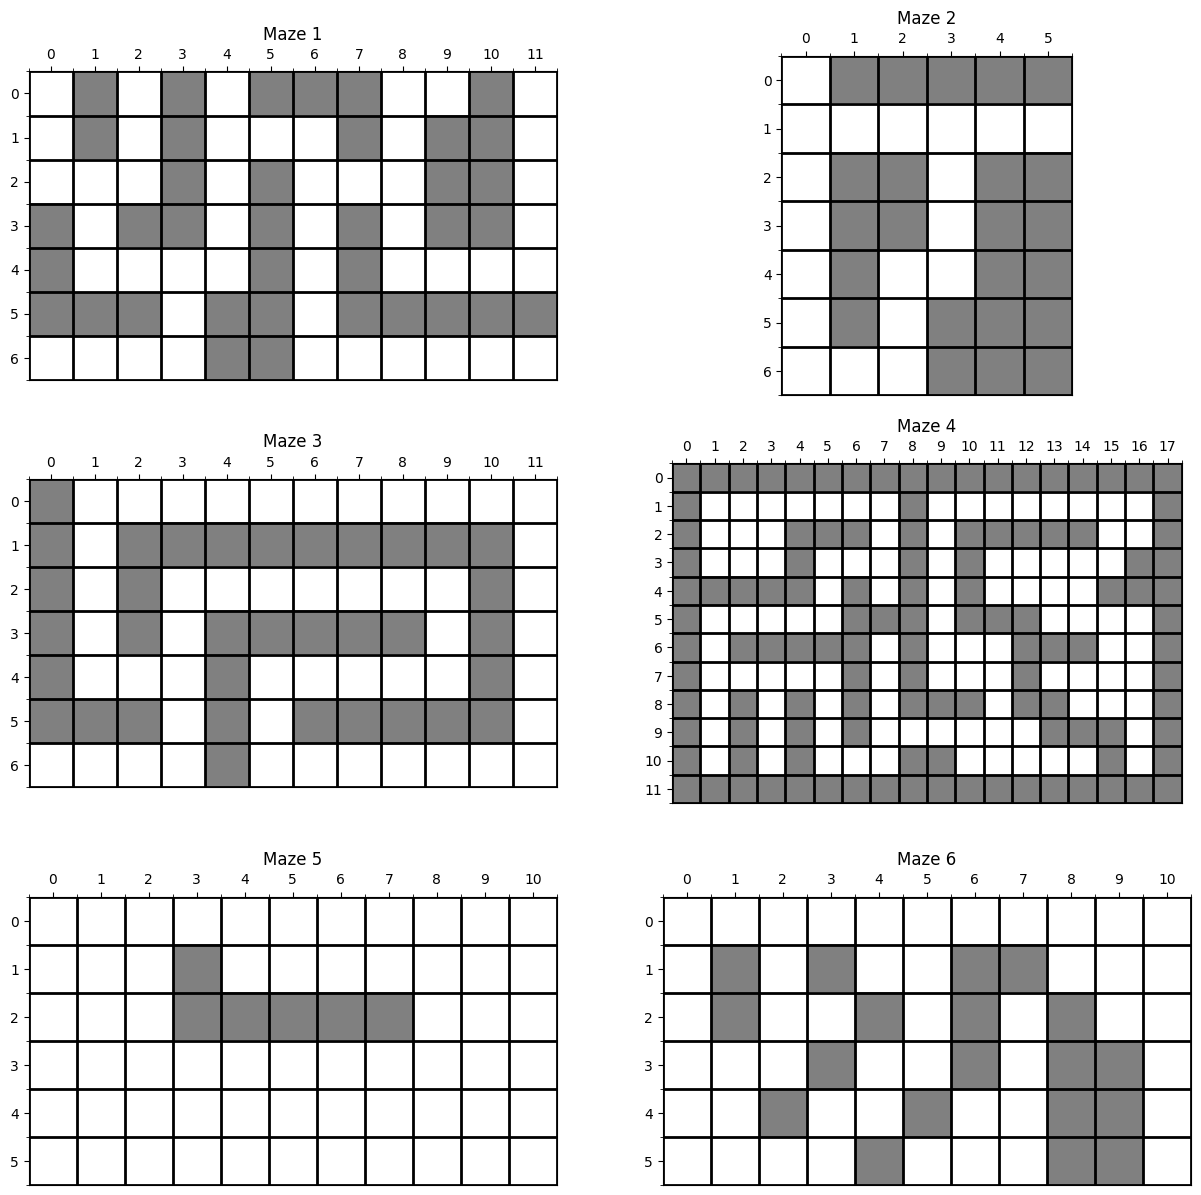

In [14]:
fig = plt.figure(figsize=(15,15))
rows = 3; cols = 2

for maze_num in range(1, len(maze_dict)-2):
    fig.add_subplot(rows, cols, maze_num)
    maze_plotter(maze_dict[f'maze_0{maze_num}'])
    plt.title(f'Maze {maze_num}')

#### **$A^{*}$ Algorithm**

In [21]:
def a_star(Q: PriorityQueue, init_x: tuple, target_x: tuple, maze_data: np.ndarray) -> dict:
    # Dict that contains maze information
    mi = {
        'maze_dim': maze_data.shape,        # Calculate maze index and Set maze constraints
        'status': False,                    # Tells whether target_x has a solution
        'came_from': {},                    # Keeps track of shortest path's nodes
        'cost_so_far': {},                  # Stores node's C(x) 
        'visited_m':np.copy(maze_data),     # Maze copy to mark visited states
        'iterations':0,                     # Iterations passed until shortest path is found
        'shortest_path': [],                # Node-by-node path to shortest route
        'final_cost': 0}                    # Shortest Path's cost

    # Initialize sub-dicts and insert init state to Frontier
    mi['came_from'][init_x] = None; mi['cost_so_far'][init_x] = 0
    Q.put(init_x, 0); mi['visited_m'].put(get_index(init_x, maze_data.shape), 2)
    
    # A* Start
    while Q.size() != 0:
        # Get State with f-value
        current = Q.get()[1]; mi['iterations'] += 1

        # Current state matches target state | SUCCESS
        if current == target_x:
            mi['status'] = True; mi['shortest_path'].append(current); mi['final_cost'] = mi['cost_so_far'][current]
            while current != init_x: prev_x = mi['came_from'][current]; mi['shortest_path'].append(prev_x); current = prev_x
            mi['shortest_path'].reverse()
            return mi

        # Explores Moore's Neighborhood
        for action in U(current, maze_data.shape):
            next = f(current, action)
            if maze_data[next[0],next[1]] == 1 or maze_data[next[0],next[1]] == 2: continue
            # Tells whether a move is diagonal
            if is_diagonal(action): new_cost = mi['cost_so_far'][current] + 14
            else: new_cost = mi['cost_so_far'][current] + 10
            if next not in mi['cost_so_far'] or new_cost < mi['cost_so_far'][next]:
                mi['cost_so_far'][next] = new_cost
                priority = new_cost + manhattan_distance(next, target_x)*10
                Q.put(next, priority)
                mi['visited_m'].put(get_index(next, maze_data.shape), 2)
                mi['came_from'][next] = current
    return mi

#### **$A^{*}$ Results** 

Maze has solution to target state? : True
Iterations to find shortest path: 43
Node-by-Node Path: (1, 4) -> (2, 4) -> (2, 3) -> (2, 2) -> (2, 1) -> (3, 1) -> (4, 1) -> (5, 1) -> (6, 1) -> (7, 1) -> (7, 2) -> (7, 3) -> (7, 4) -> (8, 4)
Path Length: 14
Shortest Path's Cost: 130


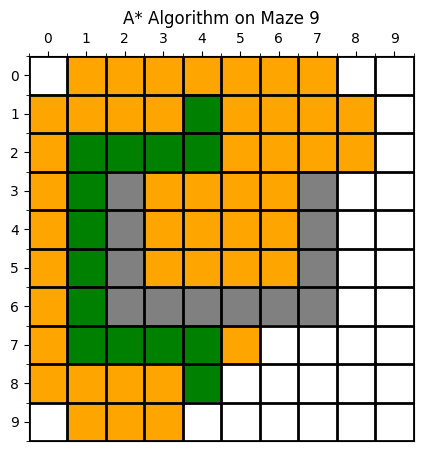

In [22]:
maze = input(f"Select Maze (1 to {len(maze_dict)}): ")
init_x = tuple(int(x) for x in input("Enter Initial State: ").split(" "))
target_x = tuple(int(x) for x in input("Enter Target State: ").split(" "))

# Shortest Path is colored Green
fig = plt.figure(figsize=(5,5))
mi = a_star(PriorityQueue(), init_x, target_x, maze_dict[f'maze_0{maze}'])
if mi['status'] != False: 
    print(f"Maze has solution to target state? : {mi['status']}")
    print(f"Iterations to find shortest path: {mi['iterations']}")
    print(f"Node-by-Node Path: {' -> '.join([str(x) for x in mi['shortest_path']])}")
    print(f"Path Length: {len(mi['shortest_path'])}")
    print(f"Shortest Path's Cost: {mi['final_cost']}")
    for x in mi['shortest_path']: mi['visited_m'].put(get_index(x, mi['visited_m'].shape),3) 
    maze_plotter(mi['visited_m'])
    plt.title(f'A* Algorithm on Maze {maze}')
else: print(f"Maze {maze} doesn't have a solution")